In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN

In [2]:
all_data = load_results_data()

100%|██████████| 108/108 [00:00<00:00, 180.33it/s]


In [3]:
MODEL_ORDER = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
               "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "vilt"]

all_data = all_data[all_data.model.isin(MODEL_ORDER)]

all_data = all_data[all_data["mask"] == "whole_brain"]

all_data

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
0,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.872143,clip_avg
1,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.862653,clip_avg
2,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.924286,clip_avg
3,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.893469,clip_avg
4,100000.0,clip,sub-01,concat,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.875918,clip_concat
...,...,...,...,...,...,...,...,...,...,...,...
307,100000.0,flava,sub-05,matched,visual_feature_cls,images,whole_brain,188225,pairwise_acc_mean,0.789388,flava_matched
308,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.809490,flava_matched
309,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.726122,flava_matched
310,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939796,flava_matched


In [4]:
DEFAULT_FEAT_OPTIONS = ["vision", "lang", "matched"]

def calc_model_feat_order(data, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

FEATS_MULTIMODAL = ["concat", "avg", "matched", "fused_mean", "fused_cls"]
multimodal_models = all_data[all_data.features.isin(FEATS_MULTIMODAL)].model.unique().tolist()
multimodal_models
# for model in MODEL_ORDER:
#     print(model, end=" ")

all_data.features.unique()

array(['avg', 'concat', 'matched', 'fused_cls', 'fused_mean',
       'fused_mean_features_safe', 'fused_mean_features_two_step',
       'multi'], dtype=object)

In [5]:
# MODELS_EARLY_FUSION = ["vilt", "bridgetower-large", "visualbert", "lxmert"]
# FEATS_FUSED = ["fused_cls", "fused_mean", "fused_mean_features_safe", "fused_mean_features_two_step"]
# # Filter out outdated data from models with early fusion
# all_data = all_data[(all_data.model.isin(MODELS_EARLY_FUSION) & all_data.features.isin(FEATS_FUSED)) | ~all_data.model.isin(MODELS_EARLY_FUSION)]

In [6]:
data_default_vision_feats = all_data.copy()
for model in all_data.model.unique():
    default_vision_feats = get_default_vision_features(model)
    # if model in ["clip", "imagebind"]:
    #     default_vision_feats = "visual_feature_mean" # TODO temporary fix for updated default feats
    data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
    
data_default_vision_feats

Selected default vision features for clip: visual_feature_cls
Selected default vision features for flava: visual_feature_cls
Selected default vision features for imagebind: visual_feature_cls
Selected default vision features for vilt: visual_feature_mean


,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
0,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.872143,clip_avg
1,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.862653,clip_avg
2,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.924286,clip_avg
3,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.893469,clip_avg
4,100000.0,clip,sub-01,concat,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.875918,clip_concat
...,...,...,...,...,...,...,...,...,...,...,...
307,100000.0,flava,sub-05,matched,visual_feature_cls,images,whole_brain,188225,pairwise_acc_mean,0.789388,flava_matched
308,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.809490,flava_matched
309,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.726122,flava_matched
310,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939796,flava_matched


## Feature comparison for multimodal models

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:66: UserWarning: 
The palette list has fewer values (8) than needed (9) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, row_order=row_order, col=col_variable, height=height, aspect=aspect, hue=hue_variable, hue_order=hue_order,
/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


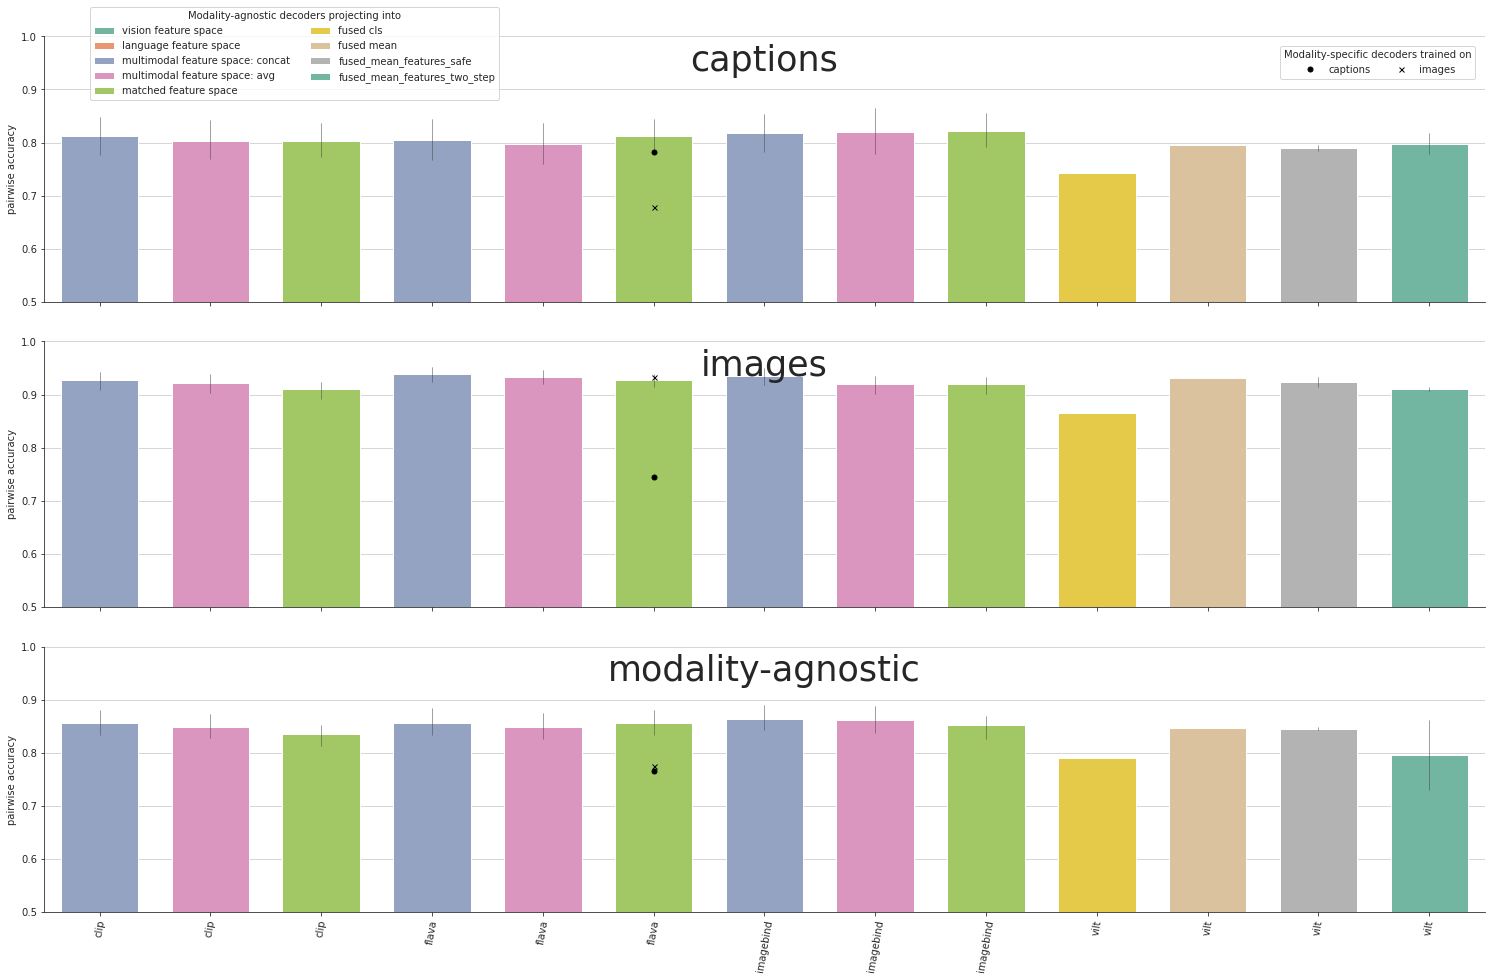

In [7]:
feat_legend = {"vision": "vision feature space", "lang": "language feature space", "concat": "multimodal feature space: concat", "avg": "multimodal feature space: avg", "matched": "matched feature space", "fused_cls": "fused cls", "fused_mean": "fused mean",
               "fused_mean_features_safe": "fused_mean_features_safe", "fused_mean_features_two_step": "fused_mean_features_two_step"}
feat_order = ["vision", "lang", "concat", "avg", "matched", "fused_cls", "fused_mean", "fused_mean_features_safe", "fused_mean_features_two_step"]
feat_order_long = [feat_legend[feat] for feat in feat_order]

data_to_plot = data_default_vision_feats.copy()

model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_concat"]
data_to_plot = data_to_plot[~data_to_plot.model_feat.isin(model_feats_exluded)].copy()

data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]

data_to_plot["features"] = data_to_plot.features.replace(feat_legend)

model_feat_order = calc_model_feat_order(data_to_plot, feat_options=feat_order)

metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order_long, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

In [8]:

data_default_feats = all_data.copy()
for model in all_data.model.unique():
    default_feats = get_default_features(model)
    default_vision_feats = get_default_vision_features(model)
    data_default_feats = data_default_feats[((data_default_feats.model == model) & (data_default_feats.features == default_feats) & (data_default_feats.vision_features == default_vision_feats)) | (data_default_feats.model != model)]
    
data_default_feats

Selected default features for clip: matched
Selected default vision features for clip: visual_feature_cls
Selected default features for flava: matched
Selected default vision features for flava: visual_feature_cls
Selected default features for imagebind: matched
Selected default vision features for imagebind: visual_feature_cls
Selected default features for vilt: fused_mean
Selected default vision features for vilt: visual_feature_mean


,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
8,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.860510,clip_matched
9,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.857551,clip_matched
10,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.918163,clip_matched
11,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.887857,clip_matched
20,100000.0,flava,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.877143,flava_matched
...,...,...,...,...,...,...,...,...,...,...,...
307,100000.0,flava,sub-05,matched,visual_feature_cls,images,whole_brain,188225,pairwise_acc_mean,0.789388,flava_matched
308,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.809490,flava_matched
309,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.726122,flava_matched
310,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939796,flava_matched


## Modality-agnostic decoding vs. modality-specific decoding

In [9]:
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY += [m+'_concat' for m in multimodal_models]

vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]
for m in multimodal_models:
    print(m, end=" ")


clip flava imagebind vilt 

### Model performance ranking

In [15]:
# feats comparison
feats = ["vision", "lang", "matched", "multi", "avg", "concat"]
for features in feats:
    for visual_feats in ["visual_feature_mean", "visual_feature_cls"]:
        print(features, visual_feats)
        
        dp = all_data.copy()
        dp = dp[dp.features == features]
        dp = dp[dp.vision_features == visual_feats]

        dp = dp[dp.training_mode == 'modality-agnostic']
        
        dp = dp[dp.metric == ACC_MODALITY_AGNOSTIC]
        for model in dp.model.unique():
            if len(dp[dp.model == model]) != len(SUBJECTS):
                print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
        scores = dp.groupby("model").value.mean().sort_values()
        if len(scores) > 0:
            print(scores)
        print("")
    
# model_order

vision visual_feature_mean

vision visual_feature_cls

lang visual_feature_mean

lang visual_feature_cls

matched visual_feature_mean

matched visual_feature_cls
unexpected number of datapoints for clip: 5
unexpected number of datapoints for imagebind: 4
model
clip         0.835633
imagebind    0.852704
flava        0.855833
Name: value, dtype: float64

multi visual_feature_mean

multi visual_feature_cls

avg visual_feature_mean

avg visual_feature_cls
model
flava        0.848452
clip         0.848912
imagebind    0.861837
Name: value, dtype: float64

concat visual_feature_mean

concat visual_feature_cls
model
clip         0.855646
flava        0.856565
imagebind    0.864031
Name: value, dtype: float64



In [11]:
model_order = ['random-flava']
for features in DEFAULT_FEAT_OPTIONS:
    print(features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == 'modality-agnostic']
    
    dp = dp[dp.metric == ACC_MODALITY_AGNOSTIC]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model").value.mean().sort_values()
    print(scores)
    model_order.extend(scores.index.values)
    
model_order

vision
Series([], Name: value, dtype: float64)
lang
Series([], Name: value, dtype: float64)
matched
unexpected number of datapoints for clip: 5
unexpected number of datapoints for imagebind: 4
model
clip         0.835633
imagebind    0.852704
flava        0.855833
Name: value, dtype: float64


['random-flava', 'clip', 'imagebind', 'flava']

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


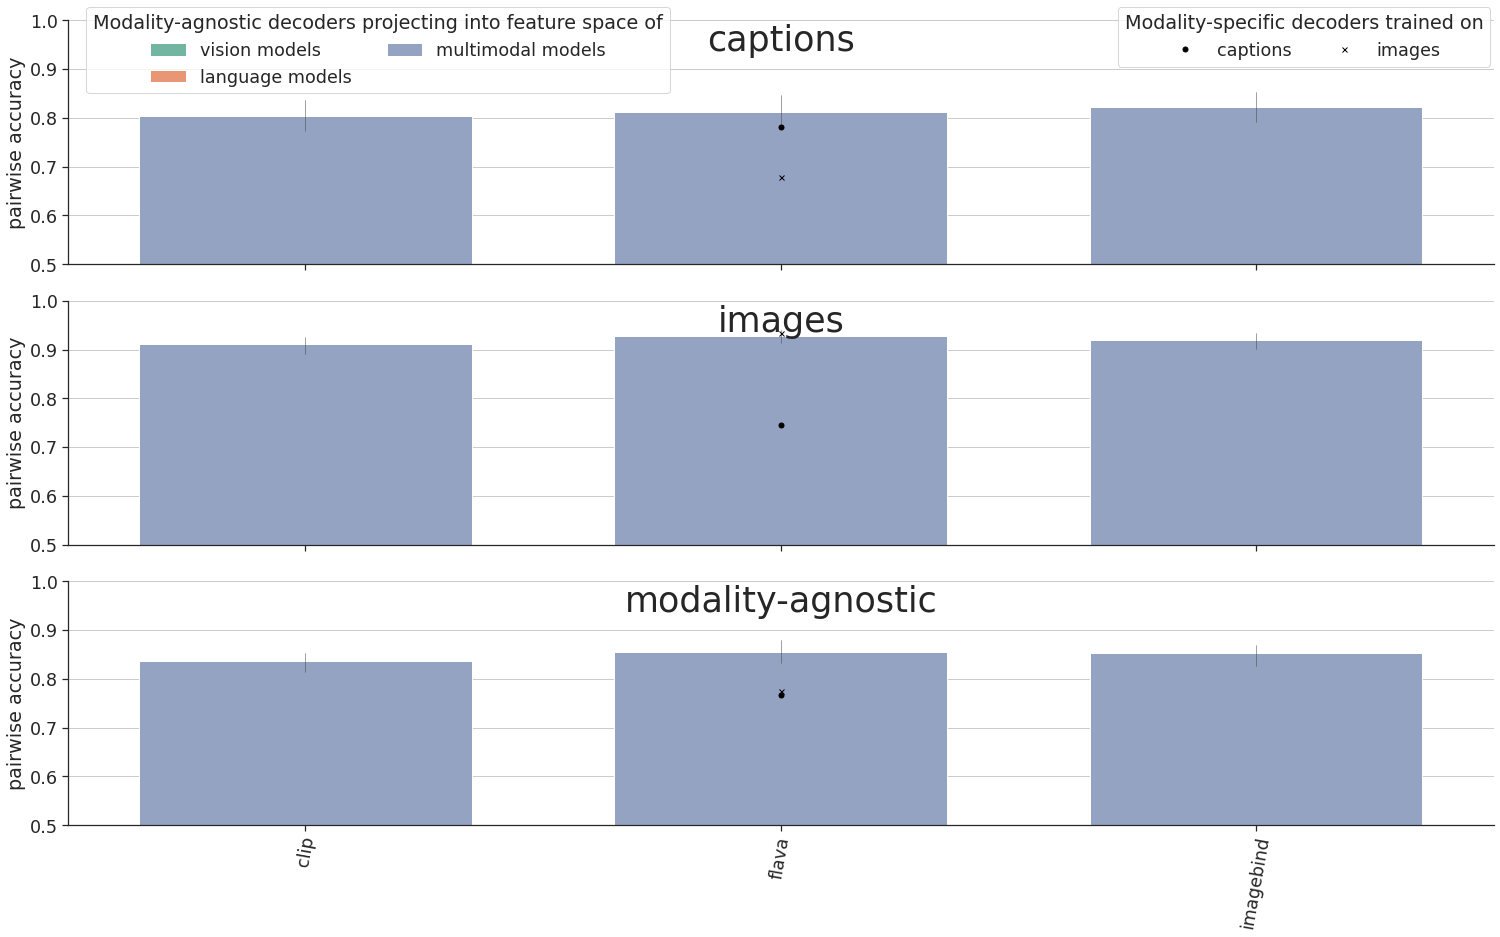

In [12]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
# data_to_plot = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()
data_to_plot = data_default_feats.copy()

# data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']
# data_to_plot = data_to_plot[(data_to_plot.model == "flava") & (data_to_plot.vision_features == 'visual_feature_cls') | (data_to_plot.model != "flava") & (data_to_plot.vision_features == 'visual_feature_mean')]


data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})

model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MEAN, ACC_MODALITY_AGNOSTIC]
metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


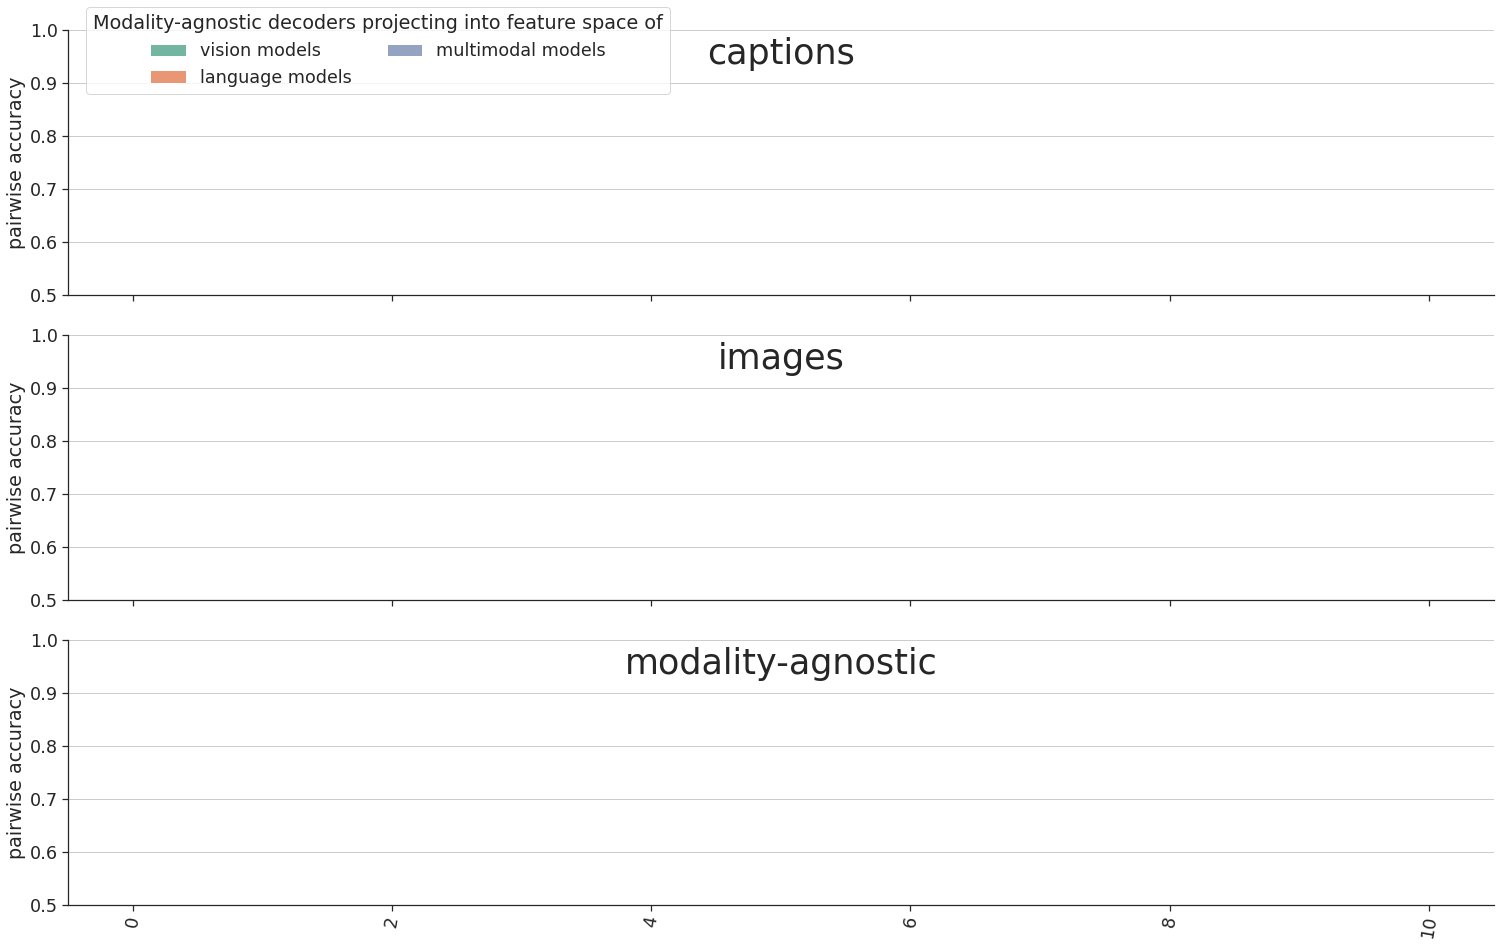

In [13]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "concat": "multimodal models"})
data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})

model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MEAN, ACC_MODALITY_AGNOSTIC]
metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1),
                             legend_bbox=(0.06,0.99), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False,
                                 plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_only_modality_agnostic.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


## CLS or mean feats for vision models

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:66: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, row_order=row_order, col=col_variable, height=height, aspect=aspect, hue=hue_variable, hue_order=hue_order,


AttributeError: 'NoneType' object has no attribute 'remove'

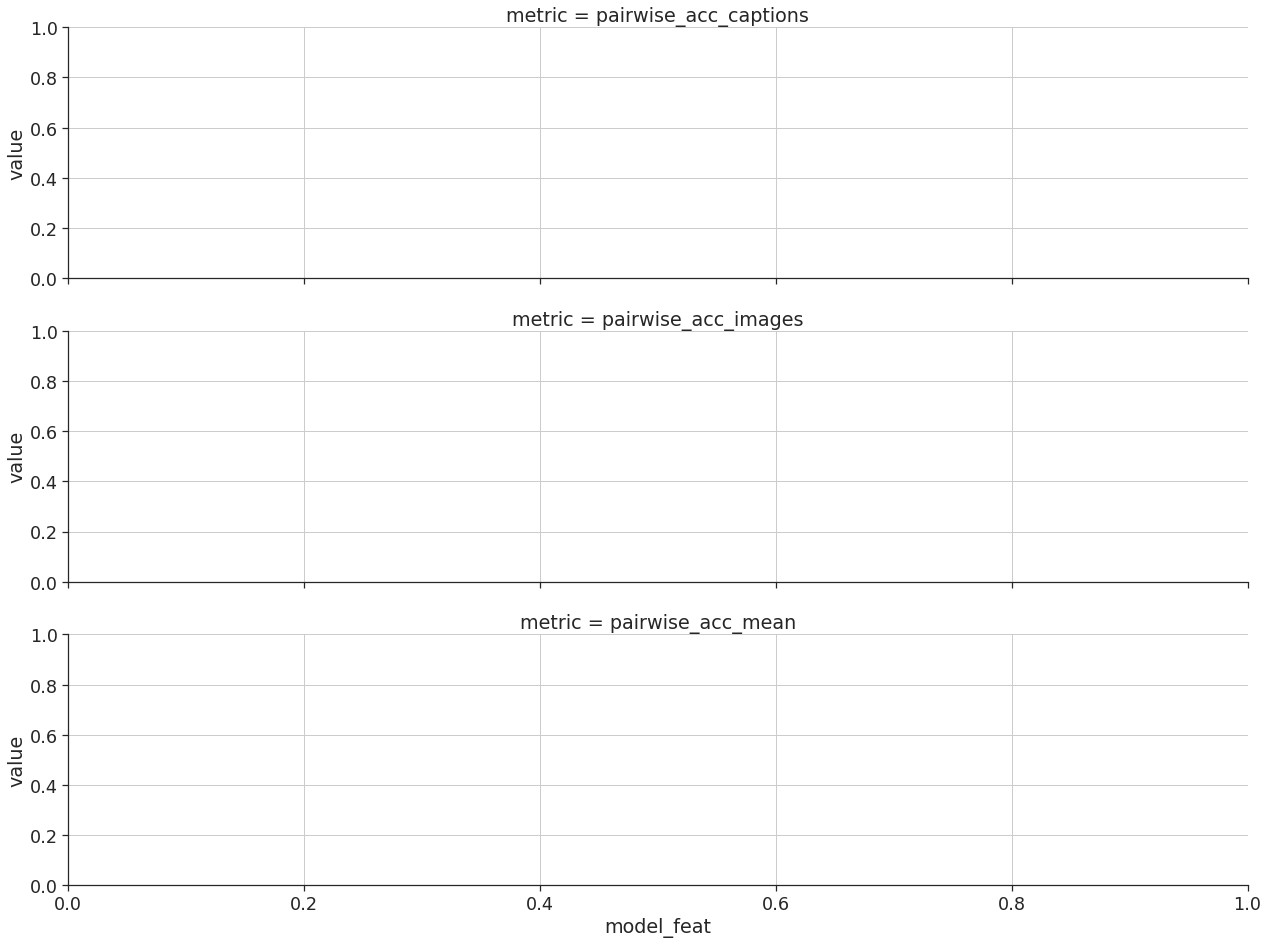

In [14]:
model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_concat"]
data_to_plot = all_data[~all_data.model_feat.isin(model_feats_exluded)].copy()

vision_models_both_options = [m for m in vision_models if len(data_to_plot[data_to_plot.model == m].vision_features.unique()) == 2]
data_to_plot = data_to_plot[data_to_plot.model.isin(vision_models_both_options)]

vision_feat_order = ["Mean vision features", "CLS token vision features"]
data_to_plot["vision_features"] = data_to_plot.vision_features.replace({"visual_feature_mean": "Mean vision features", "visual_feature_cls": "CLS token vision features"})

data_to_plot = data_to_plot[data_to_plot.training_mode == "modality-agnostic"]

model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", ACC_MEAN]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_variable="vision_features", hue_order=vision_feat_order, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.0), height=4.5, legend_title="Modality-agnostic decoders projecting into", plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_vision_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## Per-subject results

In [ ]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]


    assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


In [ ]:
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision model", "language model", "multimodal model"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision model", "lang": "language model", "matched": "multimodal model"})

model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)